In [1]:
%pylab inline
figsize(16, 8)

from __future__ import division
import xgboost as xgb 
from xgboost import plot_importance
from xgboost import plot_tree
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics
import pandas as pd
import root_numpy

Populating the interactive namespace from numpy and matplotlib


/home/lujd/anaconda2/envs/python27/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/home/lujd/anaconda2/envs/python27/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:165: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/home/lujd/anaconda2/envs/python27/lib/python2.7/site-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/home/lujd/anaconda2/envs/python27/lib/python2.7/site-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, dep

Welcome to JupyROOT 6.12/04


In [18]:
hist_settings = {'bins': 100, 'normed': True, 'alpha': 0.5}
def draw_distributions(original, target, new_original_weights, fig_name):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    for id, column in enumerate(columns_draw, 1):
        xlim = numpy.percentile(numpy.hstack([target[column]]), [0.01, 99.99]) #percentile is to calculate the p% number of a givening array
        ax=plt.subplot(3,3, id) 
        hist(target[column], range=xlim, **hist_settings)
        hist(original[column], weights=new_original_weights, range=xlim, **hist_settings)  #hist is to plot the histogram (matplotlib)
        
        plt.title(columns_draw[id-1],fontsize=20)
        tight_layout() #distance between different figs
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        # 设置坐标标签字体大小
        #ax.set_xlabel('', fontsize=20)
        #ax.set_ylabel('', fontsize=20)
        # 设置图例字体大小
        #ax.legend('', fontsize=20)    
    savefig(fig_name)

In [19]:
columns_draw = ['pap_mass','pippim_mass','ppim_mass','ppippim_mass','appip_mass','ppip_mass','appim_mass','p_pxy']
phsp_draw = root_numpy.root2array('/home/lujd/reweighting/rewighting/root/exclusive_tot.root', treename='pppipi_p',branches=columns_draw)
data_draw = root_numpy.root2array('/home/lujd/reweighting/rewighting/root/data_train.root', treename='pppipi_p',branches=columns_draw)
phsp_test = root_numpy.root2array('/home/lujd/reweighting/rewighting/root/exclusive_tot.root', treename='pppipi_p',branches=columns_draw)
data_test = root_numpy.root2array('/home/lujd/reweighting/rewighting/root/data_train.root', treename='pppipi_p',branches=columns_draw)

In [28]:

data_train=pd.DataFrame(data_draw)
phsp_train=pd.DataFrame(phsp_draw)
data_test=pd.DataFrame(data_test)
phsp_test=pd.DataFrame(phsp_test)

#data_only_Y=numpy.ones(len(data_train))
#phsp_only_Y=numpy.zeros(len(phsp_train))




original_weights=numpy.ones(len(phsp_train))


In [29]:
phsp_train.shape

(1240437, 8)

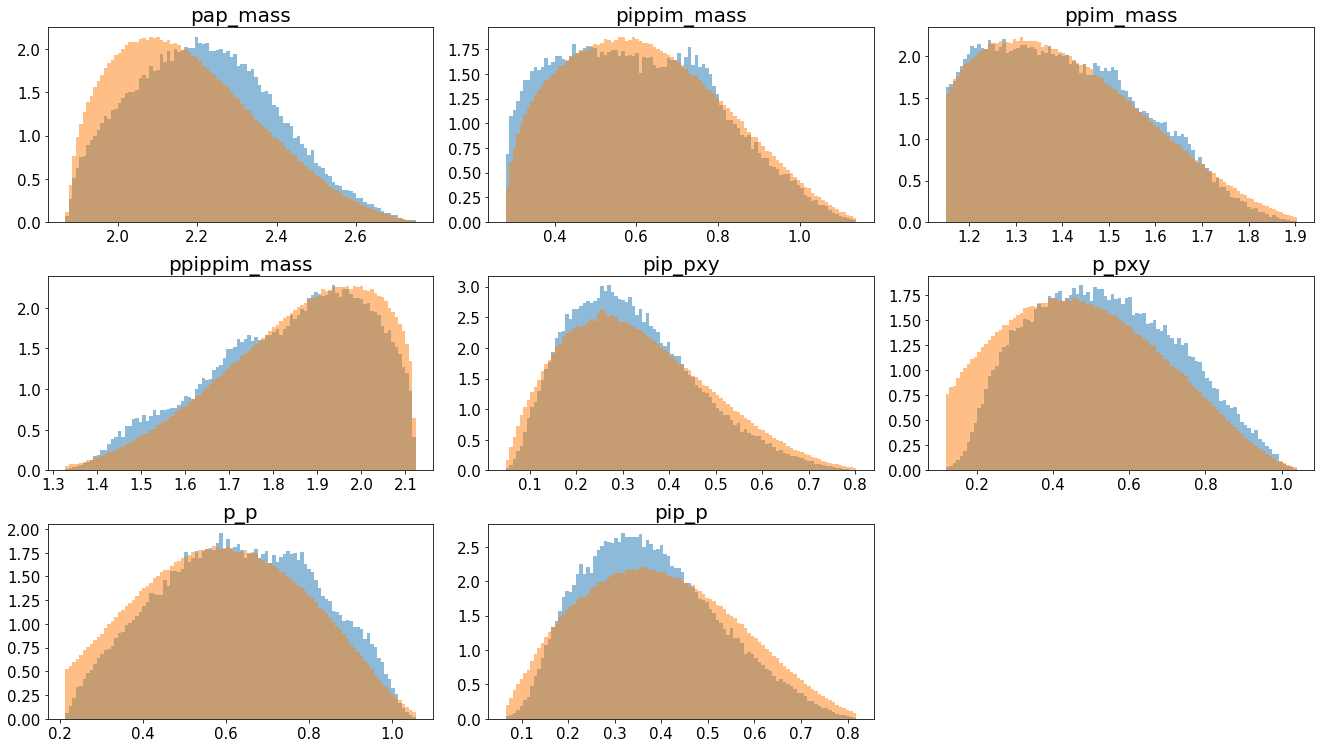

In [14]:
draw_distributions(phsp_draw, data_draw,original_weights,'phsp_target_ori.pdf')  

In [30]:
#tanslate to array format
phsp_train_ori=np.array(phsp_train)
data_train_ori=np.array(data_train)
phsp_test=np.array(phsp_test)
data_test=np.array(data_test)

from sklearn.cross_validation import train_test_split
data_train, data_test = train_test_split(data_train_ori,test_size=0)#DIY MC
phsp_train, phsp_test1 = train_test_split(phsp_train_ori,train_size=int(phsp_train.shape[0]*0.8)) #get the same number of mc with data

data_all = numpy.concatenate([data_train, phsp_train])
labels_all = numpy.array([1] * len(data_train) + [0] * len(phsp_train))

train_X, test_X,train_Y, test_Y= train_test_split(data_all,labels_all,test_size=0.3)
#print data_all,data_all.shape
#print labels_all,labels_all.shape

In [31]:
phsp_train.shape

(992349, 8)

In [32]:
#sklearn GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import metrics

#data_gbdt = numpy.concatenate([original_train, target_train])
#labels_gbdt = numpy.array([0] * len(original_train) + [1] * len(target_train))


Xtr_gbdt, Xts_gbdt, Ytr_gbdt, Yts_gbdt = train_test_split(data_all, labels_all, random_state=42, train_size=0.8)
clf_gbdt = GradientBoostingClassifier().fit(Xtr_gbdt, Ytr_gbdt)

pred_label = np.argmax(clf_gbdt.predict_proba(Xts_gbdt), axis=1)
error_rate_val = np.sum(pred_label != Yts_gbdt) / Yts_gbdt.shape[0]
print('error  = {}'.format(error_rate_val))

pr_phsp=np.array(clf_gbdt.predict_proba(phsp_train_ori).reshape(phsp_train_ori.shape[0], 2))
weight_phsp_GBT=pr_phsp[:,1]/pr_phsp[:,0]
    


/root/xiaoyj_temp/binary_root_install/root/lib/ROOT.py:318: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return _orig_ihook( name, *args, **kwds )


error  = 0.0909323934636


In [33]:
weight_phsp_GBT.shape

(1240437,)

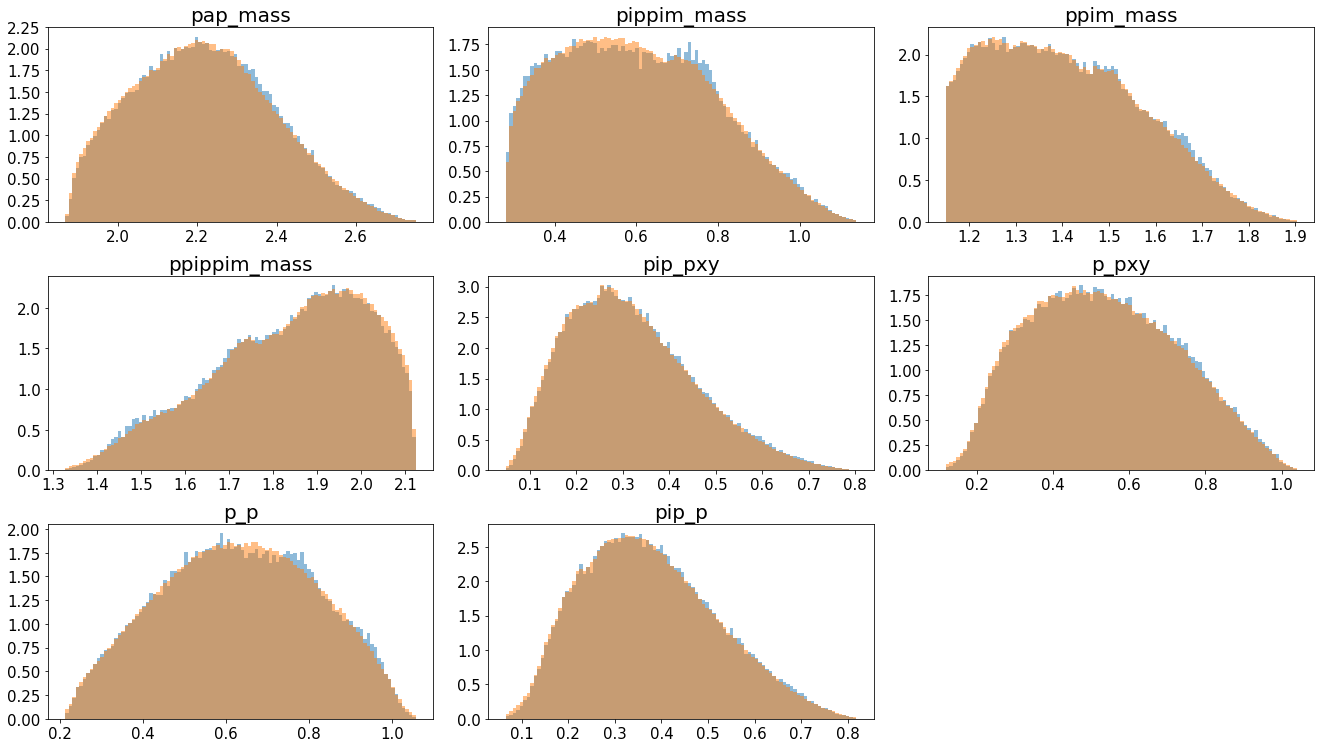

In [34]:
draw_distributions(phsp_draw, data_draw,weight_phsp_GBT,'phsp_target_GBT.pdf')